<table align="center">
   <td align="center"><a target="_blank" href="https://colab.research.google.com/github/umbcdata602/fall2020/blob/master/lab_model_evaluation.ipynb">
<img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
</table>

# Lab: Model evaluation

Analysis of breast cancer Wisconsin dataset.

### References

* [Raschka's ch06.ipynb](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch06/ch06.ipynb) -- github
* [Information about the dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) -- uci.edu


In [1]:
# Cell #3 from Raschka's ch06.ipynb
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
# Cell 5
# Column 1 of original data is either "M" (malignant) or "B" (benign)
# LabelEncoder transforms these categorical values to integers (0,1)
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [3]:
# Cell 7
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

In [24]:
# Cell 8 from Raschka's ch06.ipynb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1, solver='lbfgs'))

pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


<img src="https://github.com/rasbt/python-machine-learning-book-3rd-edition/raw/master/ch06/images/06_01.png" width="600"/>

<img src="https://github.com/rasbt/python-machine-learning-book-3rd-edition/raw/master/ch06/images/06_02.png" width="600"/>

In [8]:
# Cell 12
import numpy as np
from sklearn.model_selection import StratifiedKFold
    
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
print(np.bincount(y_train))
print(.9*np.bincount(y_train))

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

[285 170]
[256.5 153. ]
Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.014


<img src="https://github.com/rasbt/python-machine-learning-book-3rd-edition/raw/master/ch06/images/06_03.png" width="600"/>

In [9]:
# Cell 13
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


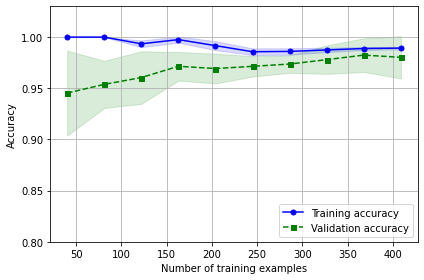

In [43]:
# Cell 15
# K-fold cross validation -- "learning_curve" accumulates statistics
# Returns train/test scores, but they're really "validation" scores
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1,
                                           solver='lbfgs', max_iter=10000))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

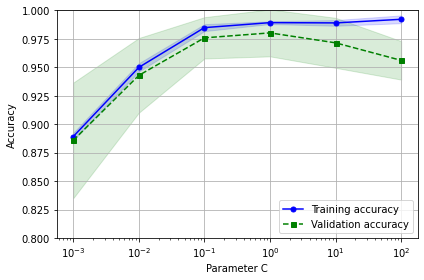

In [11]:
# Cell 16
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

In [13]:
# Cell 17
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [14]:
# Cell 18
clf = gs.best_estimator_

# clf.fit(X_train, y_train) 
# note that we do not need to refit the classifier
# because this is done automatically via refit=True.

print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974


In [15]:
# Cell 20
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

CV accuracy: 0.974 +/- 0.015


In [27]:
# Cell 21
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

CV accuracy: 0.934 +/- 0.016


In [17]:
# Cell 23
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


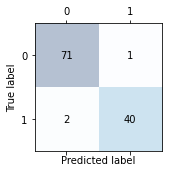

In [18]:
# Cell 24
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

In [19]:
# Cell 29
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [20]:
# Cell 30
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


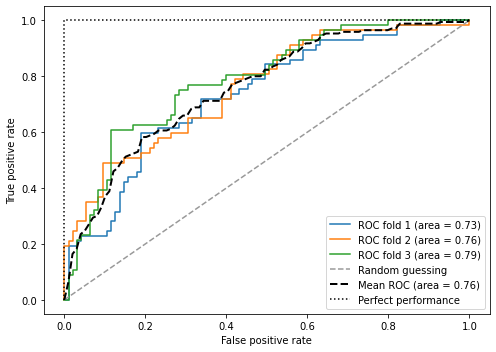

In [51]:
# Cell 31 -- ROC
from sklearn.metrics import roc_curve, auc
from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version


if scipy_version >= Version('1.4.1'):
    from numpy import interp
else:
    from scipy import interp


pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))


X_train2 = X_train[:, [4, 14]]
    

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('images/06_10.png', dpi=300)
plt.show()